# Download and install libraries

In [1]:
!pip install diffusers[training]
!pip install torch
!pip install torchvision
!pip install datasets
!pip install matplotlib
!pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Config

In [2]:
from dataclasses import dataclass

@dataclass

class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "results"  # the model name locally and on the HF Hub
    push_to_hub = False  # whether to upload the saved model to the HF Hub
    # hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    # hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

# Download augmented sickle cells dataset

In [ ]:
import os

roboflow_link = "https://app.roboflow.com/ds/rWnZw4nK78?key=RscofP3Myb" 

# DATASET AUGMENTATIONS:
# Outputs per training example: 8
# Flip: Horizontal, Vertical
# 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
# Crop: /0% Minimum Zoom, 20% Maximum Zoom
# Saturation: Between -20% and +20%
# Brightness: Between -15% and +15%

# Train: 496, Val: 17, Test: 9

# Download the dataset
!wget -O datasets/sickle_cells/sickle_cells.zip {roboflow_link}

# Unzip the dataset
!unzip datasets/sickle_cells/sickle_cells.zip -d datasets/sickle_cells/

# Load sickle cells dataset

In [3]:
from datasets import load_dataset

config.dataset_name = "imagefolder"
dataset = load_dataset(config.dataset_name, data_dir="datasets/sickle_cells")

/shared/home/v_william_cagas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 496
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 17
    })
    test: Dataset({
        features: ['image'],
        num_rows: 9
    })
})


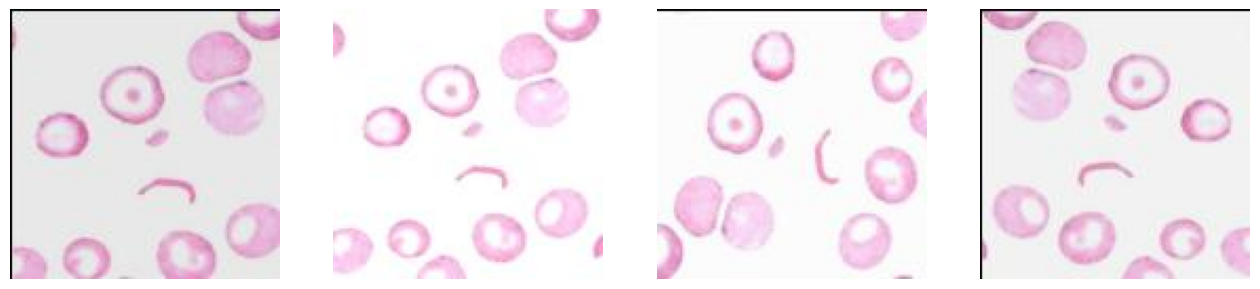

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
    
fig.show()

# Preprocess dataset images

In [5]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create dataloader

In [6]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset["train"], batch_size=config.train_batch_size, shuffle=True)

# Define UNet2DModel

In [7]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

# Define the noise scheduler

In [8]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Training Setup

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from diffusers import DDPMPipeline

import math
import PIL

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Training Function

In [11]:
import torch.nn.functional as F

from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

In [12]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/shared/home/v_william_cagas/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 0: 100%|███████████████████████████████████████████| 31/31 [00:09<00:00,  3.38it/s, loss=0.91, lr=6.2e-6, step=30]

Epoch 2: 100%|█████████████████████████████████████████| 31/31 [00:08<00:00,  3.78it/s, loss=0.105, lr=1.86e-5, step=92]

Epoch 4: 100%|████████████████████████████████████████| 31/31 [00:08<00:00,  3.73it/s, loss=0.0587, lr=3.1e-5, step=154]

Epoch 6: 100%|████████████████████████████████████████| 31/31 [00:08<00:00,  3.69it/s, loss=0.082, lr=4.34e-5, step=216]

Epoch 8: 100%|███████████████████████████████████████| 31/31 [00:0

# Clean GPUs - NO ZOMBIE PROCESSES

In [16]:
import torch

# Get the number of GPUs available
num_gpus = torch.cuda.device_count()

# Check and clear memory for each GPU
for i in range(num_gpus):
    torch.cuda.set_device(i)
    print(f"Memory allocated on GPU {i} before clearing: {torch.cuda.memory_allocated()} bytes")
    
    with torch.no_grad(): 
        torch.cuda.empty_cache()
    print(f"Memory allocated on GPU {i} after clearing: {torch.cuda.memory_allocated()} bytes")

Memory allocated on GPU 0 before clearing: 1400850944 bytes
Memory allocated on GPU 0 after clearing: 1400850944 bytes
Memory allocated on GPU 1 before clearing: 0 bytes
Memory allocated on GPU 1 after clearing: 0 bytes
Memory allocated on GPU 2 before clearing: 0 bytes
Memory allocated on GPU 2 after clearing: 0 bytes
Memory allocated on GPU 3 before clearing: 0 bytes
Memory allocated on GPU 3 after clearing: 0 bytes
Memory allocated on GPU 4 before clearing: 0 bytes
Memory allocated on GPU 4 after clearing: 0 bytes
Memory allocated on GPU 5 before clearing: 0 bytes
Memory allocated on GPU 5 after clearing: 0 bytes
Memory allocated on GPU 6 before clearing: 0 bytes
Memory allocated on GPU 6 after clearing: 0 bytes
Memory allocated on GPU 7 before clearing: 0 bytes
Memory allocated on GPU 7 after clearing: 0 bytes
